In [106]:
import os
import sys

AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../AERO_LIB/'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

PyXfoil_dir = os.path.abspath(os.path.join('../mpyXfoil/'))
if PyXfoil_dir not in sys.path:
    sys.path.append(PyXfoil_dir)

import pyXfoil as pxf
from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

# Задание формата шрифта для графиков
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [107]:
# Геометрические параметры несущей поверхности

# Параметры крыла
l_kr = 6            # размах крыла [м]
l_c = 3             # длина одной консоли [м]
b_b = 1             # бортовая хорда [м]
b_1 = 1             # концевая хорда [м]
chi_0 = radians(30)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(30)      # угол стреловидности по задней кромке [рад]

# Параметры профиля крыла
cc_b = 0.08            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.08            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.4              # относительная координата положения максимальной толщины [-]
hb = 1e-5               # относительная высота бугорков профиля [-]
rr_0 = 0                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

In [108]:
def c_x(X, q, S):
    return X / q / S

def c_y(Y, q, S):
    return Y / q / S

def m_z(M_z, q, S, L):
    return M_z / q / S / L

def m_x(M_x, q, S, L):
    return M_x / q / S / L

def c_y_to_c_ya(alpha, cy, cx):
    return cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

def c_x_to_c_xa(alpha, cy, cx):
    return cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

# Функции из Фролова
def get_c_ya_alpha_rect(lambd, c_y_a_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_y_a_alpha_profile) / (1 + c_y_a_alpha_profile*0.375/lambd)

    return c_y_a_alpha

def get_c_ya_alpha_profile_rect(lambd, c_y_a_alpha):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для профиля прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha: float - производная коэффициена c_y_a прямоугольного крыла по углу атаки
    Вывод:  c_y_a_alpha_profile: float - производной коэффициента c_y_a по углу атаки профиля прямоугольного крыла, 1/рад
    '''
    c_y_a_alpha_profile = c_y_a_alpha / (1 - c_y_a_alpha * 0.375 / lambd)
    return c_y_a_alpha_profile

def get_c_ya_alpha_rect_eta(lambd, z, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            z: float - обратное сужение крыла (z = 1/eta = 1/(b_0/b_k))
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    k = 0.995 # Поправочный коэффициент, учит. сужение крыла для 0,2 < z < 1,0
    E = 1 + 2*z / lambd / (1 + z) # Поправка Джонса, учитывает фактоор скорости по кромке, равна отношению периметра в плане к размаху

    c_ya_alpha = k * c_ya_alpha_profile / (E + c_ya_alpha_profile / np.pi / lambd)
    return c_ya_alpha

def get_c_ya_alpha_chi(lambd, chi_05, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла со стреловидностью
    
    Ввод:   lambd: float - удлинение крыла
            chi_05: float - угол стреловидности по линии средин хорд, рад
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_ya_alpha_profile * np.cos(chi_05)) / (1 + (c_ya_alpha_profile * np.cos(chi_05)) / np.pi / lambd)

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons_low_lambda(lambd):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1) по формуле Джонса
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''

    c_y_a_alpha = np.pi * lambd / 2

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons(lambd, chi_pk, chi_zk, z):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1)
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''
    eta = 1 / z # сужение крыла
    # Отношение полупериметра крыла к его размаху для трапециевидных крыльев
    pp = 1/2 * (1/np.cos(chi_pk) + 1/np.cos(chi_zk)) * (2 / lambd / (eta + 1))

    c_y_a_alpha = 2 * np.pi * lambd / (pp * lambd + 2)

    return c_y_a_alpha

def get_c_xa_i(lambd, z, chi_025, c_y_a):
    '''
    Расчет коэффициента индуктивного сопротивления крыла

    Ввод: 
        lambd: float - удлинение крыла
        z: float - облатное сужение крыла
        chi_025: float - угол стреловидности по линии 1/4 хорд, рад
        c_y_a: float - коэффициент подъемной силы крыла
    Вывод:
        c_xa_i: float - коэффициент индуктивного сопротивления
    '''
    eta = 1 / z # сужение крыла
    delta = 0.002 * lambd / np.cos(chi_025) * (3.1 - 14/eta + 20/eta/eta - 8/eta/eta/eta)

    lambd_eff = lambd / (1 + delta) # эффективное удлинение крыла
    c_xa_i = c_y_a ** 2 / np.pi / lambd_eff

    return c_xa_i

def get_c_y_a_alpha(alphas, c_y_a):
    """
    Расчет производной по углу атаки коэффициента c_y_a

    Ввод:
        alphas: np.array - массив углов атаки, град
        c_y_a: np.array - массив коэффициентов подъемной силы c_y_a
    Вывод:
        c_y_a_alpha: float - производная коэффициента подъменой силы c_y_a, 1/рад
    """
    c_y_a_alpha = (c_y_a[2] - c_y_a[0]) / (alphas[2] - alphas[0])
    return c_y_a_alpha

In [109]:
# Результаты расчета в Ansys

alpha_Ansys = np.array([0, 2, 4, 8, 12, 16])

cxa_Ansys = np.array([0.00772824, 0.01104705, 0.01704285, 0.0370828 , 0.06568292, 0.17810125])
cya_Ansys = np.array([0.13245655, 0.27776655, 0.42350608, 0.70470581, 0.9251901, 0.90648008])
mza_Ansys = np.array([0.173725  , 0.32941974, 0.4866035 , 0.78956769, 1.00669404, 0.95231465])

# Параметры невозмущенного потока
H_Ansys = 0                         # Высота полета
rho_Ansys = atmo.rho(H_Ansys)       # Плотность воздуха
a_Ansys = atmo.a(H_Ansys)           # Скорость звука
nu_Ansys = 15.06e-6                 # Кинематическая вязкость воздуха

M = 0.2                             # Число Маха
V = M * a_Ansys                     # Скорость потока
q = rho_Ansys * V ** 2 / 2          # Скоростной напор

Re_Ansys = V * b_b / nu_Ansys       # Число Рейнольдса для крыла

In [110]:
Airfoil = SubsonicProfile(b_b, cc, xx_c, rr_0, hb, 'naca')      # Создание экземпляра класса дозвукового профиля
IP = IsolatedPlane(S_kr, lambda_kr, zeta_kr, chi_05, Airfoil)   # Создание экземпляра класса изолированного крыла

In [111]:
# Расчет крыла по Лебедеву-Чернобровкину

cya_LiCH, cxa_LiCH, mza_LiCH = [], [], []

alphas = np.linspace(0, 20, 31)

for alf in alphas:
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))
    cya_LiCH.append(IP.c_ya(M, np.deg2rad(alf)))

In [112]:
# Расчет АДХ профиля крыла по Xfoil
S = pxf.Session()
EXP = pxf.Experiment()

AIRFOIL = 'NACA2208'        # Имя профиля (имя профиля или файл с координатами профиля)
Re = Re_Ansys               # Число Рейнольдса
ITER = 150                  # Число итераций
INIT_TYPE_ADX = 'alpha'     # Инициализация расчета (по c_ya или alpha)
value_min = 0               # Значение c_ya или alpha
value_max = 18
inc = 2

Res_ADX = S.get_ADX(AIRFOIL, Re, INIT_TYPE_ADX, value_min, value_max, inc, ITER)
alpha_airfoil, c_ya_airfoil, c_xa_airfoil = Res_ADX['alpha'], Res_ADX['c_ya'], Res_ADX['c_xa']

In [113]:
# Расчет производных коэффициента c_y_a по углу атаки alpha
c_y_a_alpha_Xfoil = (c_ya_airfoil[1] - c_ya_airfoil[0]) / (alpha_airfoil[1] / 57.3 - alpha_airfoil[0] / 57.3)
# c_y_a_alpha_Xfoil = get_c_y_a_alpha(alpha_airfoil, c_ya_airfoil)        # Производная c_y_a_alpha из Xfoil
c_y_a_alpha_1 = get_c_ya_alpha_rect(lambda_kr, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_2 = get_c_ya_alpha_rect_eta(lambda_kr, 1, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_3 = get_c_ya_alpha_chi(lambda_kr, chi_05, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_4 = get_c_ya_alpha_Dzhons_low_lambda(lambda_kr) / 57.3
c_y_a_alpha_5 = get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1) / 57.3

delta_c_ya = c_ya_airfoil[0] / (1 + c_y_a_alpha_Xfoil * 0.375 / lambda_kr)

In [114]:
# Производная крыла
(cya_Ansys[1] - cya_Ansys[0]) / (alpha_Ansys[1] / 57.3 - alpha_Ansys[0] / 57.3)
# c_y_a_alpha_Xfoil

4.1631314999999995

In [115]:
def get_alpha_kr(M):
        alpha_kr_array = np.array([[0, 13.04233502],
        [0.0625, 12.88640565],
        [0.125, 12.82261655],
        [0.1875, 12.81552876],
        [0.25, 12.85805499],
        [0.3125, 13.00689657],
        [0.375, 13.22661554],
        [0.4375, 13.51012311],
        [0.5, 13.89994652],
        [0.5625, 14.38899798],
        [0.625, 14.99180071],
        [0.6875, 15.70730979],
        [0.75, 16.62871039],
        [0.8125, 17.72021594],
        [0.875, 19.08814178],
        [0.9375, 20.61199697],
        [1, 22.19964178],
        [1.0625, 23.85816297],
        [1.125, 25.51668416],
        [1.1875, 27.06180272],
        [1.25, 28.55021948],
        [1.3125, 30.10242533],
        [1.375, 31.62628052],
        [1.4375, 33.14304793],
        [1.46875, 34.05027346]])
        akr = interp1d(alpha_kr_array[:,0], alpha_kr_array[:,1])
        return float(akr(M))
alpha_kr = get_alpha_kr(M)-1

alpha_cya = np.linspace(0, alpha_kr, 20)

def polinome(x):
        return (-2.636e-05*x**4 + 0.008567*x**3 - 0.1611*x**2 + 0.3011*x - 0.) * 0.04

x = np.linspace(0, 5, 21)

In [125]:
(-2.636e-05*x**4 + 0.008567*x**3 - 0.1611*x**2 + 0.3011*x - 0.) * 0.04
0.3011 * 0.04

0.012044

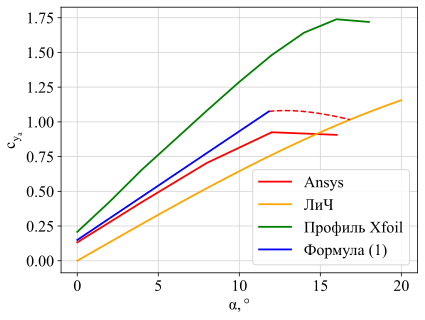

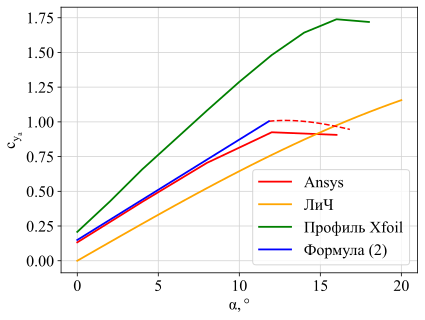

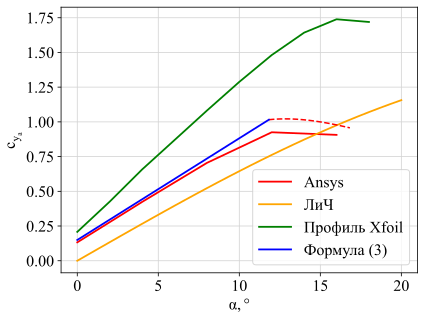

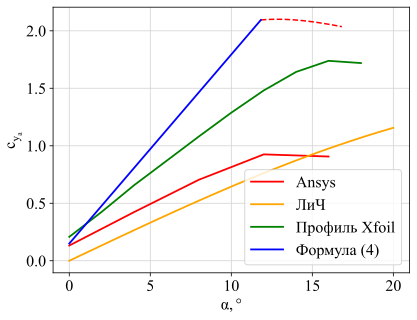

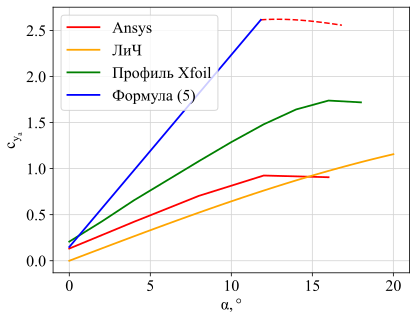

In [116]:
# Визуализация АДХ профиля крыла

plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alphas, cya_LiCH, label = 'ЛиЧ', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = 'Профиль Xfoil', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_1 + delta_c_ya, ls = '--', color = 'red')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (1)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alphas, cya_LiCH, label = 'ЛиЧ', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = 'Профиль Xfoil', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_2 + delta_c_ya, ls = '--', color = 'red')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_2 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alphas, cya_LiCH, label = 'ЛиЧ', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = 'Профиль Xfoil', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_3 + delta_c_ya, ls = '--', color = 'red')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_3 + delta_c_ya, label = 'Формула (3)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alphas, cya_LiCH, label = 'ЛиЧ', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = 'Профиль Xfoil', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_4 + delta_c_ya, ls = '--', color = 'red')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_4 + delta_c_ya, label = 'Формула (4)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alphas, cya_LiCH, label = 'ЛиЧ', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = 'Профиль Xfoil', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_5 + delta_c_ya, ls = '--', color = 'red')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_5 + delta_c_ya, label = 'Формула (5)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

# plt.plot(alpha_airfoil, c_xa_airfoil + get_c_xa_i(lambda_kr, 1, 0, c_ya_airfoil))
# plt.plot(alpha_Ansys, cxa_Ansys)
# plt.show()

Text(0.5, 0, '$\\alpha, \\degree$')

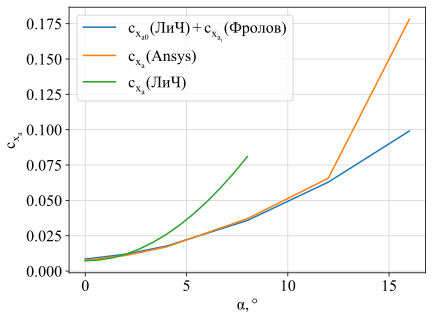

In [117]:
cxa0_LiCH = []
cxa_prof_LiCH = []
for alf in alpha_Ansys:
    cxa0_LiCH.append(IP.c_xa0(M, 0.9))
    cxa_prof_LiCH.append(IP.c_xa_pr(M))

# Сопротивление крыла
cxai = get_c_xa_i(lambda_kr, 1, np.deg2rad(15), alpha_Ansys * c_y_a_alpha_2 + delta_c_ya)
# cxa_wing = c_xa_airfoil + cxai
plt.plot(alpha_Ansys, (cxai + cxa_prof_LiCH), label = '$c_{x_{a0}}(ЛиЧ) + c_{x_{a_i}}(Фролов)$')
plt.plot(alpha_Ansys, cxa_Ansys, label = '$c_{x_a}(Ansys)$')
plt.plot(alphas[:13], cxa_LiCH[:13], label = '$c_{x_a}(ЛиЧ)$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')

plt.ylabel('$c_{x_a}$')
plt.xlabel('$\\alpha, \degree$')

# plt.plot(alpha_Ansys, cxa_prof_LiCH)
# plt.plot(alpha_Ansys, cxa0_LiCH)

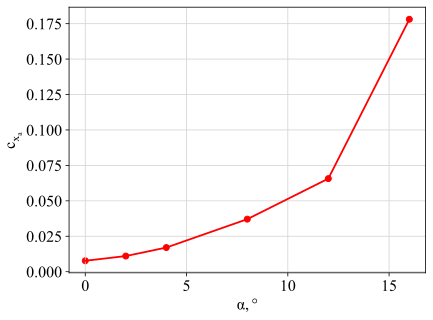

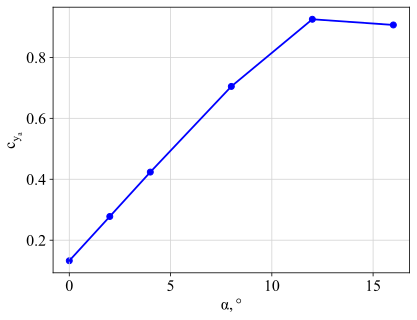

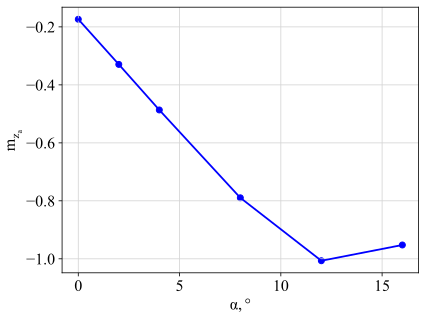

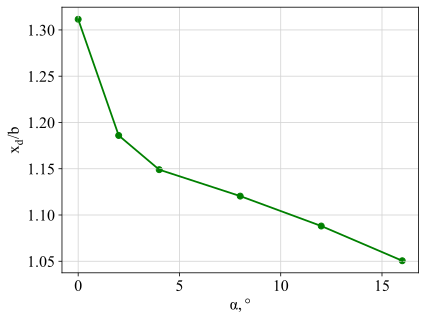

In [118]:
# Графики для РПЗ

# График c_x_a (alpha)
plt.plot(alpha_Ansys, cxa_Ansys, color = 'red', lw = 1.8)
plt.scatter(alpha_Ansys, cxa_Ansys, color = 'red')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.show()

# График c_y_a (alpha)
plt.plot(alpha_Ansys, cya_Ansys, color = 'blue', lw = 1.8)
plt.scatter(alpha_Ansys, cya_Ansys, color = 'blue')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.show()

# График m_z_a (alpha)
plt.plot(alpha_Ansys,  - (mza_Ansys / cya_Ansys) * cya_Ansys, color = 'blue', lw = 1.8)
plt.scatter(alpha_Ansys, - (mza_Ansys / cya_Ansys) * cya_Ansys, color = 'blue')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$m_{z_a}$')
plt.show()

# График x_d (alpha)
plt.plot(alpha_Ansys, (mza_Ansys / cya_Ansys), color = 'green', lw = 1.8)
plt.scatter(alpha_Ansys, mza_Ansys/cya_Ansys, color = 'green')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_d/b$')
plt.show()

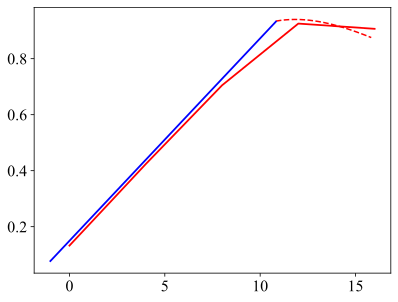

In [119]:
alpha_kr_array = np.array([[0, 13.04233502],
        [0.0625, 12.88640565],
        [0.125, 12.82261655],
        [0.1875, 12.81552876],
        [0.25, 12.85805499],
        [0.3125, 13.00689657],
        [0.375, 13.22661554],
        [0.4375, 13.51012311],
        [0.5, 13.89994652],
        [0.5625, 14.38899798],
        [0.625, 14.99180071],
        [0.6875, 15.70730979],
        [0.75, 16.62871039],
        [0.8125, 17.72021594],
        [0.875, 19.08814178],
        [0.9375, 20.61199697],
        [1, 22.19964178],
        [1.0625, 23.85816297],
        [1.125, 25.51668416],
        [1.1875, 27.06180272],
        [1.25, 28.55021948],
        [1.3125, 30.10242533],
        [1.375, 31.62628052],
        [1.4375, 33.14304793],
        [1.46875, 34.05027346]])

poli = np.array([[0.000000, 0.000000], 	
                [2.544774, -0.370903], 	
                [4.470867, -1.167951], 	
                [5.941377, -2.168914], 	
                [7.126585, -3.250082], 	
                [8.528312, -4.232204], 	
                [9.881036, -4.870417], 	
                [11.587102, -5.337893], 	
                [13.139718, -5.479081], 	
                [14.865133, -5.479081], 	
                [17.139718, -5.479081]])

poli =  np.array([[0.000000 , 0.000000], 	
        [0.600351, -0.023890 ],	
        [1.130553, -0.077042], 	
        [1.609033, -0.151252], 	
        [2.047225, -0.241579], 	
        [2.458036, -0.346263],	
        [2.766718, -0.438069],	
        [3.224918, -0.595975], 	
        [3.652367, -0.767707], 	
        [3.970958, -0.911900], 	
        [4.416424, -1.138218],	
        [4.681014, -1.287151], 	
        [5.016590, -1.492737], 	
        [5.358693, -1.722991], 	
        [5.726592, -1.996104], 	
        [6.013909, -2.229656], 	
        [6.336645, -2.515616], 	
        [6.569859, -2.739541],	
        [6.821333, -2.980361], 	
        [6.988659, -3.131114], 	
        [7.358232, -3.439790], 	
        [7.788431, -3.761308], 	
        [8.047466, -3.937277], 	
        [8.332237, -4.116708], 	
        [8.734526, -4.346939], 	
        [9.008538, -4.489190], 	
        [9.586261, -4.753282], 	
        [9.796844, -4.838129], 	
        [10.070580, -4.939757], 	
        [10.434929, -5.060354], 	
        [10.893543, -5.189262], 	
        [11.279513, -5.278708], 	
        [11.560197, -5.333138],	
        [11.872846, -5.383457], 	
        [12.343573, -5.439087], 	
        [12.820183, -5.471138], 	
        [13.139718, -5.479081]])

x = poli[:,0]
y = poli[:,1]
t = np.polyfit(x,y, 4)
f = np.poly1d(t)

def polinome(x):
        return -2.636e-05*x**4 + 0.008567*x**3 - 0.1611*x**2 + 0.3011*x - 0.1487

# plt.plot(x,y)
# x=np.array([12, 13, 14, 15])
x = np.linspace(0, 5, 21)
plt.plot(x+(alpha_kr-1), c_y_a_alpha_2*(alpha_kr-1)*1.01 + polinome(x)*0.04 + delta_c_ya, ls = '--', color = 'red')
# plt.plot(x, c_y_a_alpha_2*(alpha_kr) + polinome(x) + delta_c_ya, ls = '--', color = 'red')
plt.plot((alpha_cya-1), (alpha_cya-1) * c_y_a_alpha_2 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')

In [120]:
poli[:,0]

array([ 0.      ,  0.600351,  1.130553,  1.609033,  2.047225,  2.458036,
        2.766718,  3.224918,  3.652367,  3.970958,  4.416424,  4.681014,
        5.01659 ,  5.358693,  5.726592,  6.013909,  6.336645,  6.569859,
        6.821333,  6.988659,  7.358232,  7.788431,  8.047466,  8.332237,
        8.734526,  9.008538,  9.586261,  9.796844, 10.07058 , 10.434929,
       10.893543, 11.279513, 11.560197, 11.872846, 12.343573, 12.820183,
       13.139718])

In [121]:
c_y_a_alpha_2*alpha_kr

0.8548281981385067